### **Before running, please make sure you complete steps 1-4 below first. Otherwise, running this code file directly will result in a compatibility error.**

**STEP 1:** Set hardware accelerator to default 'None'. (Do not use 'GPU' accelerator)

**STEP 2:** Download these library versions below. (very important!) (Inconsistencies with these versions below will result in compatibility errors.)
* `pip install gensim==4.1.2`
* `pip install jieba`
* `pip install tensorflow==2.5.0`

In [ ]:
# pip install gensim==4.1.2

In [ ]:
# pip install jieba

In [ ]:
# pip install tensorflow==2.5.0

**STEP 3:** After finishing STEP 2, comment the three lines of code above. 

**STEP 4:** *Restart* and run all the code. (Don't forget to restart)

# Chinese Text Sentiment Analysis Based on Deep Learning

#### ***Label:***

$$positive->label('美味')=1$$
$$negative->label('难吃')=0$$

#### ***Flowchart:***
<center><img width=500 src="https://i.imgur.com/Ln5oRY1.png"></center>

## Import

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba  # jieba: Chinese words segmentation module
from gensim.models import KeyedVectors  # gensim: load the pre-trained word vector
import warnings
import os
import random
warnings.filterwarnings("ignore")
import bz2  # unzip
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import scipy 
from scipy.interpolate import BSpline, make_interp_spline
from sklearn.model_selection import train_test_split  # Split training and test samples
# using tensorflow's keras interface
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional, Dropout
# from tensorflow.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

## Load Pre-trained Word Vectors Model
###### In the word vector model, each word is an index, which corresponds to a vector of length 300. Since the LSTM neural network model does not directly process Chinese text, we need to first perform word separation operations and then convert the words into word vectors.

* Because downloading large files directly from google drive will report a security error, I stored the word vector model and dataset as a zip file in my github account, and then downloaded them from github to google colab. The github link for this project is:   
https://github.com/Shao210934641/Chinese-Text-Sentiment-Analysis

In [ ]:
# Place the downloaded word vectors in the embeddings folder in the root directory and unzip
!wget "https://media.githubusercontent.com/media/Shao210934641/Chinese-Text-Sentiment-Analysis/main/embeddings/sgns.zhihu.bigram.bz2" -P "/content/embeddings"
with open("embeddings/sgns.zhihu.bigram", 'wb') as new_file, open("embeddings/sgns.zhihu.bigram.bz2", 'rb') as file:
    decompressor = bz2.BZ2Decompressor()
    for data in iter(lambda : file.read(100 * 1024), b''):
        new_file.write(decompressor.decompress(data))

--2022-08-13 18:34:32--  https://media.githubusercontent.com/media/Shao210934641/Chinese-Text-Sentiment-Analysis/main/embeddings/sgns.zhihu.bigram.bz2
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 237423897 (226M) [application/octet-stream]
Saving to: ‘/content/embeddings/sgns.zhihu.bigram.bz2’

sgns.zhihu.bigram.b 100%[===================>] 226.42M   200MB/s    in 1.1s    

2022-08-13 18:34:47 (200 MB/s) - ‘/content/embeddings/sgns.zhihu.bigram.bz2’ saved [237423897/237423897]



In [ ]:
# Load pre-trained Chinese word separation embedding using gensim 
cn_model = KeyedVectors.load_word2vec_format('embeddings/sgns.zhihu.bigram', binary=False, unicode_errors="ignore")

In [ ]:
# Input a Chinese word and output a vector of words of length 300
embedding_dim = cn_model['青岛'].shape[0]
print('The length of the word vector is {}'.format(embedding_dim))
cn_model['青岛']

The length of the word vector is 300


array([ 8.375510e-01,  4.208510e-01, -2.799180e-01,  5.622690e-01,
       -8.997970e-01,  5.272690e-01,  9.496400e-01,  4.563700e-02,
       -9.810400e-02, -2.630750e-01, -1.524345e+00,  7.652050e-01,
       -1.986810e-01, -6.065320e-01,  5.041090e-01, -4.938500e-01,
        5.872340e-01, -1.234050e-01, -4.244760e-01,  1.889090e-01,
        7.961510e-01,  6.705470e-01,  7.920700e-02,  5.041190e-01,
       -5.473530e-01, -6.844260e-01,  4.471700e-01, -2.957340e-01,
       -2.229900e-01,  1.689930e-01,  3.720270e-01, -1.595700e-01,
       -3.491800e-02,  2.385590e-01, -2.851160e-01, -3.496570e-01,
       -2.146670e-01,  1.279030e-01,  1.851230e-01, -8.933700e-02,
       -3.738830e-01, -3.261810e-01,  8.310600e-02, -2.764490e-01,
        1.571830e-01, -6.430000e-03, -4.535830e-01,  3.596070e-01,
       -4.212470e-01,  4.759860e-01,  1.874830e-01, -1.392510e-01,
       -6.330000e-04,  1.503450e-01, -2.699750e-01, -3.896300e-02,
       -9.544230e-01,  1.075360e-01, -5.690130e-01,  5.670360e

In [ ]:
# Calculate the cosine similarity of two words 
cn_model.similarity('英国', '伦敦')

0.55973804

In [ ]:
# Input a Chinese word and find the 10 most similar words to it 
cn_model.most_similar(positive=['人民币'], topn=10)

[('美元', 0.7081582546234131),
 ('港币', 0.6911839842796326),
 ('日元', 0.6810632348060608),
 ('汇率', 0.679571270942688),
 ('欧元', 0.6542581915855408),
 ('欧元和', 0.6420362591743469),
 ('英镑', 0.6394895911216736),
 ('贬值', 0.636674165725708),
 ('韩元', 0.6353235840797424),
 ('卢布', 0.6327826976776123)]

In [ ]:
# Enter a set of Chinese words and find the word that is not in the same category
test_words = '英国 德国 法国 中国 帅哥'
test_words_result = cn_model.doesnt_match(test_words.split())
print('In '+ '['+test_words+']' +':\nThe word that is not in the same category is: %s' %test_words_result)

In [英国 德国 法国 中国 帅哥]:
The word that is not in the same category is: 帅哥


**datasets**  
The datasets are placed in two separate .txt files: 
* <I>positive_samples.txt</I> (2000 Chinese positive reviews, label=1）
* <I>negative_samples.txt</I> (2000 Chinese negative reviews, label=0）

## Data Preprocessing 

In [ ]:
train_texts_orig = []  # Store all reviews, one string per case
train_target = []  # Store all labels. The first 2,000 reviews are positive, the last 2,000 are negative. 

# I stored the datasets as a zip file in my github account. 
# The github link for this project is: https://github.com/Shao210934641/Chinese-Text-Sentiment-Analysis
!wget "https://raw.githubusercontent.com/Shao210934641/Chinese-Text-Sentiment-Analysis/main/datasets/datasets.zip" -P "/content/datasets"
!unzip "/content/datasets/datasets.zip" -d "/content/datasets"

with open("datasets/datasets/positive_samples.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        dic = eval(line)
        train_texts_orig.append(dic["text"])
        train_target.append(dic["label"])

with open("datasets/datasets/negative_samples.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        dic = eval(line)
        train_texts_orig.append(dic["text"])
        train_target.append(dic["label"])

--2022-08-13 18:35:29--  https://raw.githubusercontent.com/Shao210934641/Chinese-Text-Sentiment-Analysis/main/datasets/datasets.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 697597 (681K) [application/zip]
Saving to: ‘/content/datasets/datasets.zip’

datasets.zip        100%[===================>] 681.25K  --.-KB/s    in 0.05s   

2022-08-13 18:35:29 (12.5 MB/s) - ‘/content/datasets/datasets.zip’ saved [697597/697597]

Archive:  /content/datasets/datasets.zip
   creating: /content/datasets/datasets/
  inflating: /content/datasets/__MACOSX/._datasets  
  inflating: /content/datasets/datasets/positive_samples.txt  
  inflating: /content/datasets/__MACOSX/datasets/._positive_samples.txt  
  inflating: /content/datasets/datasets/negative_samples.txt  
  inf

In [ ]:
print(len(train_texts_orig))
print(len(train_target))

4000
4000


**remove punctuation, jieba word segmentation and tokenize**  
* First we remove the punctuation from each sample. 
* Then using jieba word segmentation, which returns a generator -> cut. 
* However, the generator cannot be tokenized directly, so we also need to convert it to a list -> cut_list. 
* Next, Index it. 
* Finally, the text evaluated in each case becomes a segment of indexed numbers corresponding to the words in the pre-trained word vectors model.

In [ ]:
train_tokens = []
for text in train_texts_orig:
    # Remove punctuation
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # jieba word segmentation
    cut = jieba.cut(text)  # jieba's output is a generator -> cut
    cut_list = [ i for i in cut ]  # Convert the generator to list -> cut_list 
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.key_to_index[word]  # Convert words to index
            # cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            cut_list[i] = 0  # If the word is not in the dictionary, output 0
    train_tokens.append(cut_list)  # train_tokens is a long list containing 4000 small lists, corresponding to each evaluation

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.029 seconds.
Prefix dict has been built successfully.


**normalising index length**  
Because each review is of a different length, it would be a waste of computing resources to simply take the longest one and fill the others to the same length, so we take a compromise length.

In [ ]:
# Get lengths of all tokens
num_tokens = [ len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)

In [ ]:
# The average length of tokens
np.mean(num_tokens)

71.42575

In [ ]:
# The longest tokens length
np.max(num_tokens)

1540

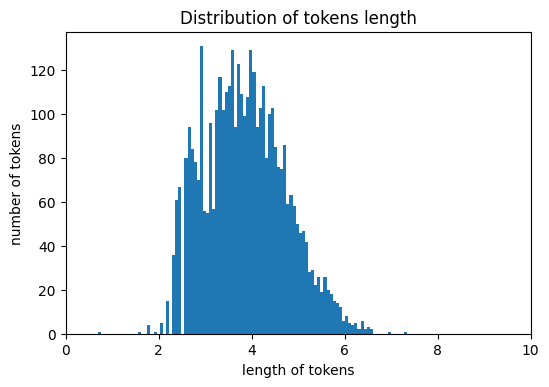

In [ ]:
# Display the distribution of tokens length 
plt.figure(dpi=100)
plt.hist(np.log(num_tokens), bins = 100)
plt.xlim((0,10))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.savefig('tokens distribution')
plt.show()

In [ ]:
# Take the mean of tokens + standard deviation of tokens *2. The distribution of tokens lengths is approximated as a normal distribution
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

236

In [ ]:
# When tokens are taken to be 236 in length, about 95% of the sample is covered. 
# (Under-length tokens will be padding and over-length tokens will be trimmed later)
np.sum( num_tokens < max_tokens ) / len(num_tokens)

0.9565

**reverse tokenize**  
Define a function to convert the index into readable text, which is important for debugging.

In [ ]:
# Convert tokens to text
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            # text = text + cn_model.index2word[i]
            text = text + cn_model.index_to_key[i]
        else:
            text = text + ' '
    return text

In [ ]:
# After tokenize and revert to text, the punctuation is gone
reverse = reverse_tokens(train_tokens[0])
reverse

'早餐太差无论去多少人那边也不加食品的酒店应该重视一下这个问题了房间本身很好'

In [ ]:
# original text
train_texts_orig[0]

'早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。\n\n房间本身很好。'

**create the embedding matrix**  
* Now, we need to create an embedding matrix. According to keras, we need to prepare a dimension of $(numwords, embedddingdim)$ of the matrix, where numwords represents the number of words we use, and emdeddingdim is 300 in the pre-trained word vector model we are using now, with each word represented by a vector of length 300.
* Note that we use only the first 50k most frequently used words. There are 2.6 million words in this pre-trained word vector model, and it would be a waste of computational resources to use them all for the classification problem.



In [ ]:
embedding_dim

300

In [ ]:
num_words = 50000  # Use only the first 50,000 words
embedding_matrix = np.zeros((num_words, embedding_dim))  # Initialise embedding_matrix
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index_to_key[i]]
    # embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')  # embedding_matrix is a matrix of [num_words, embedding_dim]. 
print('Dimension of embedding_matrix:', embedding_matrix.shape)  # Dimension of embedding_matrix

Dimension of embedding_matrix: (50000, 300)


**padding and truncating**  
After we convert the text into indexes, the length of each string of indexes is not equal, so in order to facilitate the training of the model, we need to normalise the length of the indexes. Above, we have chosen 236 samples, which can cover 95% of the length of the training samples.  
Next, we do padding and truncating. We generally use the 'pre' method, which will fill in the front of the text indexes with 0. Because, according to some research materials in practice, if you fill in the text indexes after 0, it will have some adverse effects on the model.

In [ ]:
# Padding and truncating. The input train_tokens is a list, and the returned train_pad is a numpy array. 
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

In [ ]:
# Words beyond the 50,000 word vector are replaced by 0
train_pad[ train_pad>=num_words ] = 0

In [ ]:
# Fill in the front of the text index with 0. Text at the end
train_pad[33]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
# create target labels, 1 for the first 2000 samples, 0 for the next 2000
train_target = np.array(train_target)

In [ ]:
# 90% for training, 10% for test
X_train, X_test, y_train, y_test = train_test_split(train_pad, train_target, test_size=0.1, random_state=12)

## Model Building 

Now we build the LSTM model using keras. The first layer of the model is the embedding layer, and only after we have transformed the token index into a word vector matrix can the text be processed by the neural network. Keras provides an embedding interface to avoid tedious sparse matrix operations.   
The matrix entered in the Embedding layer is: $$(batchsize, maxtokens)$$
The output matrix is: $$(batchsize, maxtokens, embeddingdim)$$

In [ ]:
# Model 1: LSTM
model_1 = Sequential()
model_1.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_tokens, trainable=False))
# model_1.add(LSTM(units=128, return_sequences=True))
# model_1.add(LSTM(units=64, return_sequences=True))
model_1.add(LSTM(units=32, return_sequences=True))
# model_1.add(Dropout(0.8))
model_1.add(LSTM(units=16, return_sequences=True))
# model_1.add(Dropout(0.8))
model_1.add(LSTM(units=4, return_sequences=False)) 
# model_1.add(Dropout(0.8))
model_1.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=1e-3)
# optimizer = RMSprop(lr=1e-3)
model_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 236, 300)          15000000  
_________________________________________________________________
lstm (LSTM)                  (None, 236, 32)           42624     
_________________________________________________________________
lstm_1 (LSTM)                (None, 236, 16)           3136      
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 15,046,101
Trainable params: 46,101
Non-trainable params: 15,000,000
_________________________________________________________________


In [ ]:
# Model 2: GRU 
model_2 = Sequential()
model_2.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_tokens, trainable=False))
# model_2.add(GRU(units=128, return_sequences=True))
# model_2.add(GRU(units=64, return_sequences=True))
model_2.add(GRU(units=32, return_sequences=True))
# model_2.add(Dropout(0.8))
model_2.add(GRU(units=16, return_sequences=True))
# model_2.add(Dropout(0.8))
model_2.add(GRU(units=4, return_sequences=False))
# model_2.add(Dropout(0.8))
model_2.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=1e-3)
# optimizer = RMSprop(lr=1e-3)
model_2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 236, 300)          15000000  
_________________________________________________________________
gru (GRU)                    (None, 236, 32)           31968     
_________________________________________________________________
gru_1 (GRU)                  (None, 236, 16)           2352      
_________________________________________________________________
gru_2 (GRU)                  (None, 4)                 252       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 15,034,577
Trainable params: 34,577
Non-trainable params: 15,000,000
_________________________________________________________________


In [ ]:
# Model 3: BiLSTM 
model_3 = Sequential()
model_3.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_tokens, trainable=False))
# model_3.add(Bidirectional(LSTM(units=128, return_sequences=True)))
# model_3.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model_3.add(Bidirectional(LSTM(units=32, return_sequences=True)))
# model_3.add(Dropout(0.8))
model_3.add(Bidirectional(LSTM(units=16, return_sequences=True)))
# model_3.add(Dropout(0.8))
model_3.add(Bidirectional(LSTM(units=4, return_sequences=False)))
# model_3.add(Dropout(0.8))
model_3.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=1e-3)
# optimizer = RMSprop(lr=1e-3)
model_3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 236, 300)          15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 236, 64)           85248     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 236, 32)           10368     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 8)                 1184      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 15,096,809
Trainable params: 96,809
Non-trainable params: 15,000,000
_________________________________________________________________


In [ ]:
# Model 4: LSTM-BiLSTM combined 
model_4 = Sequential()
model_4.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_tokens, trainable=False))
# model_4.add(Bidirectional(LSTM(units=128, return_sequences=True)))
# model_4.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model_4.add(Bidirectional(LSTM(units=32, return_sequences=True)))
# model_4.add(Dropout(0.8))
model_4.add(LSTM(units=16, return_sequences=True))
# model_4.add(Dropout(0.8))
model_4.add(LSTM(units=4, return_sequences=False))
# model_4.add(Dropout(0.8)) 
model_4.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=1e-3)
# optimizer = RMSprop(lr=1e-3)
model_4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 236, 300)          15000000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 236, 64)           85248     
_________________________________________________________________
lstm_7 (LSTM)                (None, 236, 16)           5184      
_________________________________________________________________
lstm_8 (LSTM)                (None, 4)                 336       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 15,090,773
Trainable params: 90,773
Non-trainable params: 15,000,000
_________________________________________________________________


## Model Training 

In [ ]:
# Create a storage point for the weights
path_checkpoint_1 = 'sentiment_checkpoint_1.keras'
path_checkpoint_2 = 'sentiment_checkpoint_2.keras'
path_checkpoint_3 = 'sentiment_checkpoint_3.keras'
path_checkpoint_4 = 'sentiment_checkpoint_4.keras'
checkpoint_1 = ModelCheckpoint(filepath=path_checkpoint_1, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)
checkpoint_2 = ModelCheckpoint(filepath=path_checkpoint_2, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)
checkpoint_3 = ModelCheckpoint(filepath=path_checkpoint_3, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)
checkpoint_4 = ModelCheckpoint(filepath=path_checkpoint_4, monitor='val_loss',
                                      verbose=1, save_weights_only=True,
                                      save_best_only=True)

In [ ]:
# Define early stopping. If the validation loss does not improve within 5 epochs then stop training
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
# Automatic learning rate reduction
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1, min_lr=1e-8, patience=0,
                                       verbose=1)

In [ ]:
# Define the callback function
callbacks_1 = [earlystopping, checkpoint_1, lr_reduction]
callbacks_2 = [earlystopping, checkpoint_2, lr_reduction]
callbacks_3 = [earlystopping, checkpoint_3, lr_reduction]
callbacks_4 = [earlystopping, checkpoint_4, lr_reduction]

In [ ]:
# Model 1 training
history_1 = model_1.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=callbacks_1)

Epoch 1/20
26/26 [==============================] - 34s 941ms/step - loss: 0.6429 - accuracy: 0.6355 - val_loss: 0.5492 - val_accuracy: 0.7694

Epoch 00001: val_loss improved from inf to 0.54921, saving model to sentiment_checkpoint_1.keras
Epoch 2/20
26/26 [==============================] - 23s 881ms/step - loss: 0.5092 - accuracy: 0.7707 - val_loss: 0.5185 - val_accuracy: 0.7639

Epoch 00002: val_loss improved from 0.54921 to 0.51855, saving model to sentiment_checkpoint_1.keras
Epoch 3/20
26/26 [==============================] - 22s 844ms/step - loss: 0.4379 - accuracy: 0.8235 - val_loss: 0.4649 - val_accuracy: 0.8028

Epoch 00003: val_loss improved from 0.51855 to 0.46487, saving model to sentiment_checkpoint_1.keras
Epoch 4/20
26/26 [==============================] - 22s 855ms/step - loss: 0.3965 - accuracy: 0.8432 - val_loss: 0.4191 - val_accuracy: 0.8139

Epoch 00004: val_loss improved from 0.46487 to 0.41911, saving model to sentiment_checkpoint_1.keras
Epoch 5/20
26/26 [======

In [ ]:
# Model 2 training
history_2 = model_2.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=callbacks_2)

Epoch 1/20
26/26 [==============================] - 27s 779ms/step - loss: 0.6501 - accuracy: 0.6346 - val_loss: 0.6017 - val_accuracy: 0.7028

Epoch 00001: val_loss improved from inf to 0.60171, saving model to sentiment_checkpoint_2.keras
Epoch 2/20
26/26 [==============================] - 20s 787ms/step - loss: 0.5538 - accuracy: 0.7346 - val_loss: 0.5313 - val_accuracy: 0.7472

Epoch 00002: val_loss improved from 0.60171 to 0.53126, saving model to sentiment_checkpoint_2.keras
Epoch 3/20
26/26 [==============================] - 19s 746ms/step - loss: 0.4743 - accuracy: 0.7840 - val_loss: 0.4219 - val_accuracy: 0.8194

Epoch 00003: val_loss improved from 0.53126 to 0.42191, saving model to sentiment_checkpoint_2.keras
Epoch 4/20
26/26 [==============================] - 20s 750ms/step - loss: 0.3727 - accuracy: 0.8478 - val_loss: 0.3519 - val_accuracy: 0.8611

Epoch 00004: val_loss improved from 0.42191 to 0.35186, saving model to sentiment_checkpoint_2.keras
Epoch 5/20
26/26 [======

In [ ]:
# Model 3 training
history_3 = model_3.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=callbacks_3)

Epoch 1/20
26/26 [==============================] - 62s 2s/step - loss: 0.6337 - accuracy: 0.6793 - val_loss: 0.5578 - val_accuracy: 0.8028

Epoch 00001: val_loss improved from inf to 0.55781, saving model to sentiment_checkpoint_3.keras
Epoch 2/20
26/26 [==============================] - 43s 2s/step - loss: 0.5535 - accuracy: 0.7796 - val_loss: 0.5309 - val_accuracy: 0.8056

Epoch 00002: val_loss improved from 0.55781 to 0.53088, saving model to sentiment_checkpoint_3.keras
Epoch 3/20
26/26 [==============================] - 44s 2s/step - loss: 0.5499 - accuracy: 0.7698 - val_loss: 0.6656 - val_accuracy: 0.6083

Epoch 00003: val_loss did not improve from 0.53088

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/20
26/26 [==============================] - 44s 2s/step - loss: 0.6168 - accuracy: 0.6639 - val_loss: 0.5803 - val_accuracy: 0.7139

Epoch 00004: val_loss did not improve from 0.53088

Epoch 00004: ReduceLROnPlateau reducing learning rate

In [ ]:
# Model 4 training
history_4 = model_4.fit(X_train, y_train,
          validation_split=0.1, 
          epochs=20,
          batch_size=128,
          callbacks=callbacks_4)

Epoch 1/20
26/26 [==============================] - 45s 1s/step - loss: 0.6210 - accuracy: 0.6802 - val_loss: 0.5543 - val_accuracy: 0.7361

Epoch 00001: val_loss improved from inf to 0.55433, saving model to sentiment_checkpoint_4.keras
Epoch 2/20
26/26 [==============================] - 35s 1s/step - loss: 0.5044 - accuracy: 0.8009 - val_loss: 0.4606 - val_accuracy: 0.8361

Epoch 00002: val_loss improved from 0.55433 to 0.46064, saving model to sentiment_checkpoint_4.keras
Epoch 3/20
26/26 [==============================] - 34s 1s/step - loss: 0.4714 - accuracy: 0.8037 - val_loss: 0.4213 - val_accuracy: 0.8528

Epoch 00003: val_loss improved from 0.46064 to 0.42132, saving model to sentiment_checkpoint_4.keras
Epoch 4/20
26/26 [==============================] - 38s 1s/step - loss: 0.4208 - accuracy: 0.8432 - val_loss: 0.3878 - val_accuracy: 0.8556

Epoch 00004: val_loss improved from 0.42132 to 0.38775, saving model to sentiment_checkpoint_4.keras
Epoch 5/20
26/26 [==================

**Display the validation loss change curve during training**

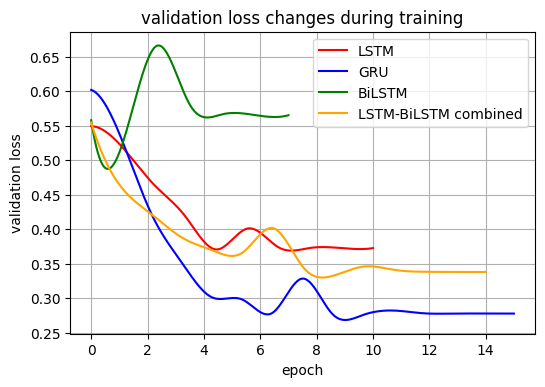

In [ ]:
# Use the history[] function in keras to get the validation loss for each of the four models.
A1 = history_1.history['val_loss']
A2 = history_2.history['val_loss']
A3 = history_3.history['val_loss']
A4 = history_4.history['val_loss']

# Display
x = np.linspace(0, len(A1), len(A1))
x_smooth_1 = np.linspace(x.min(), x.max(), 400)
y_smooth_1 = make_interp_spline(x, A1)(x_smooth_1)
# plt.figure(figsize=(10, 5), dpi=400)
plt.figure(dpi=100)
plt.grid(True)
plt.plot(x_smooth_1, y_smooth_1, label='LSTM', color='r')

x = np.linspace(0, len(A2), len(A2))
x_smooth_2 = np.linspace(x.min(), x.max(), 400)
y_smooth_2 = make_interp_spline(x, A2)(x_smooth_2)
plt.plot(x_smooth_2, y_smooth_2, label='GRU', color='blue')

x = np.linspace(0, len(A3), len(A3))
x_smooth_3 = np.linspace(x.min(), x.max(), 400)
y_smooth_3 = make_interp_spline(x, A3)(x_smooth_3)
plt.plot(x_smooth_3, y_smooth_3, label='BiLSTM', color='green')

x = np.linspace(0, len(A4), len(A4))
x_smooth_4 = np.linspace(x.min(), x.max(), 400)
y_smooth_4 = make_interp_spline(x, A4)(x_smooth_4)
plt.plot(x_smooth_4, y_smooth_4, label='LSTM-BiLSTM combined', color='orange')

plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.legend()
plt.title('validation loss changes during training')
plt.savefig('val_loss')
plt.show()

****Display the validation accuracy change curve during training****

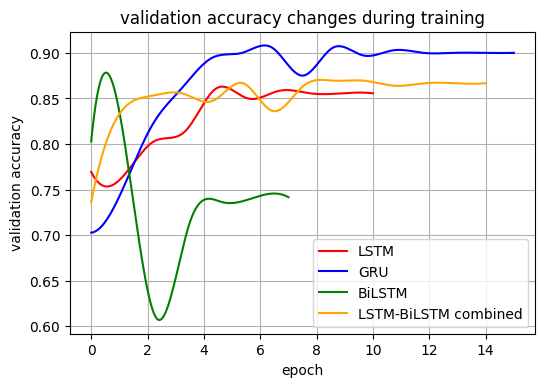

In [ ]:
# Use the history[] function in keras to get the validation accuracy for each of the four models.
B1 = history_1.history['val_accuracy']
B2 = history_2.history['val_accuracy']
B3 = history_3.history['val_accuracy']
B4 = history_4.history['val_accuracy']

# Display
x = np.linspace(0, len(B1), len(B1))
x_smooth_1 = np.linspace(x.min(), x.max(), 400)
y_smooth_1 = make_interp_spline(x, B1)(x_smooth_1)
# plt.figure(figsize=(10, 5), dpi=400)
plt.figure(dpi=100)
plt.grid(True)
plt.plot(x_smooth_1, y_smooth_1, label='LSTM', color='r')

x = np.linspace(0, len(B2), len(B2))
x_smooth_2 = np.linspace(x.min(), x.max(), 400)
y_smooth_2 = make_interp_spline(x, B2)(x_smooth_2)
plt.plot(x_smooth_2, y_smooth_2, label='GRU', color='blue')

x = np.linspace(0, len(B3), len(B3))
x_smooth_3 = np.linspace(x.min(), x.max(), 400)
y_smooth_3 = make_interp_spline(x, B3)(x_smooth_3)
plt.plot(x_smooth_3, y_smooth_3, label='BiLSTM', color='green')

x = np.linspace(0, len(B4), len(B4))
x_smooth_4 = np.linspace(x.min(), x.max(), 400)
y_smooth_4 = make_interp_spline(x, B4)(x_smooth_4)
plt.plot(x_smooth_4, y_smooth_4, label='LSTM-BiLSTM combined', color='orange')

plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.legend()
plt.title('validation accuracy changes during training')
plt.savefig('val_acc')
plt.show()

## Model Test

First, we use model.evaluate( ) to input the test data (x_test) and test labels (y_test) and output the test accuracy for the four models.




In [ ]:
result_1 = model_1.evaluate(X_test, y_test)
print('Test Accuracy:{0:.2%} (LSTM)'.format(result_1[1]))
result_2 = model_2.evaluate(X_test, y_test)
print('Test Accuracy:{0:.2%} (GRU)'.format(result_2[1]))
result_3 = model_3.evaluate(X_test, y_test)
print('Test Accuracy:{0:.2%} (BiLSTM)'.format(result_3[1]))
result_4 = model_4.evaluate(X_test, y_test)
print('Test Accuracy:{0:.2%} (LSTM-BiLSTM combined)'.format(result_4[1]))

13/13 [==============================] - 1s 101ms/step - loss: 0.3873 - accuracy: 0.8525
Test Accuracy:85.25% (LSTM)
13/13 [==============================] - 1s 90ms/step - loss: 0.2890 - accuracy: 0.8950
Test Accuracy:89.50% (GRU)
13/13 [==============================] - 2s 182ms/step - loss: 0.5752 - accuracy: 0.7150
Test Accuracy:71.50% (BiLSTM)
13/13 [==============================] - 2s 146ms/step - loss: 0.3497 - accuracy: 0.8725
Test Accuracy:87.25% (LSTM-BiLSTM combined)


Based on the model evaluate result in step 1, we found that the test accuracy of model X is the highest, so we use model X as the benchmark for the next prediction and error analysis phases.

We then use model.predict( ) function to input test data(X_test) and output the prediction result. We then compare the prediction result with the test label(y_test) and output the corresponding confusion matrix heatmap.

In [ ]:
test_pred = model_2.predict(X_test) 
A = []
for i in test_pred:
  if i >= 0.5:
    A.append(1)  # When the predicted value is greater than or equal to 0.5, the corresponding label is set to 1. 
  else:
    A.append(0)  # When the predicted value is less than 0.5, the corresponding label is set to 0. 

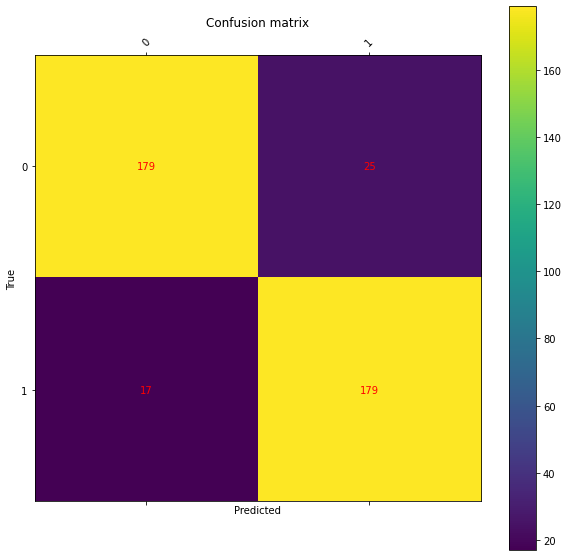

In [ ]:
# confusion matrix
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    # cm = confusion_matrix(y_test, preds, labels)
    cm = confusion_matrix(y_test,A,labels=[0,1])  # get confusion matrix
    fig = plt.figure(figsize=(10,10))
    # fig = plt.figure(figsize=(10,10), dpi=500)
    # fig = plt.figure(dpi=100)
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="red")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('hi')
    plt.show()

confusion_matrix_heatmap(y_test, A)

Next, We define a new prediction function to predict the label of the custom input text.

In [ ]:
def predict_sentiment(text):
    print(text, end=" ")
    # remove punctuation
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # word segmentation
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            # cut_list[i] = cn_model.vocab[word].index
            cut_list[i] = cn_model.key_to_index[word]
            if cut_list[i] >= 50000:
                cut_list[i] = 0
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                           padding='pre', truncating='pre')
    # predict 
    result = model_2.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        # print('-> prediction: positive','-> output=%.2f'%coef)
        print('-> output=%.2f'%coef, '-> positive')
    else:
        print('-> output=%.2f'%coef, '-> negative')

In [ ]:
test_list = [
    '酒店设施不是新的，服务态度很不好',
    '酒店卫生条件非常不好',
    '床铺非常舒适',
    '房间很凉，不给开暖气',
    '房间很凉爽，空调冷气很足',
    '酒店环境不好，住宿体验很不好',
    '房间隔音不到位' ,
    '晚上回来发现没有打扫卫生',
    '因为过节所以要我临时加钱，比团购的价格贵'
]
for text in test_list:
    predict_sentiment(text)

酒店设施不是新的，服务态度很不好 -> output=0.12 -> negative
酒店卫生条件非常不好 -> output=0.11 -> negative
床铺非常舒适 -> output=0.69 -> positive
房间很凉，不给开暖气 -> output=0.14 -> negative
房间很凉爽，空调冷气很足 -> output=0.85 -> positive
酒店环境不好，住宿体验很不好 -> output=0.08 -> negative
房间隔音不到位 -> output=0.18 -> negative
晚上回来发现没有打扫卫生 -> output=0.19 -> negative
因为过节所以要我临时加钱，比团购的价格贵 -> output=0.20 -> negative


## Error Analysis 

The trained model is first experimented on 400 test sets to obtain the corresponding test set prediction labels *y_pred*, which are then compared with the true test set labels *y_test*. next, the index of false positive and false negative samples for all classification errors is counted. And at the end, the original text of FP and FN is output based on the *reverse_tokens* function, and the error analysis is performed. 

false positive samples: predicted negative sentiment, but actually positive (pred=0, label=1)  
false negative samples: predicted positive sentiment, but actually negative (pred=1, label=0)

In [ ]:
y_pred = model_2.predict(X_test)
y_pred = y_pred.T[0]
y_pred = [1 if p>= 0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

In [ ]:
y_actual = np.array(y_test)

In [ ]:
F_P = []
F_N = []

for i in range(400):
  if y_pred[i]==0 and y_actual[i]==1:
    F_P.append(i)
  if y_pred[i]==1 and y_actual[i]==0:
    F_N.append(i)

print('The indexes of false positive samples are as follows:')
print(F_P)
print(" ")
print('The indexes of false negative samples are as follows:')
print(F_N)
print(" ")
print('The total number of misclassified samples is:')
print(len(F_P+F_N))

The indexes of false positive samples are as follows:
[73, 101, 123, 127, 130, 160, 189, 207, 211, 228, 231, 238, 246, 267, 365, 373, 391]
 
The indexes of false negative samples are as follows:
[5, 14, 15, 59, 75, 87, 91, 103, 138, 148, 182, 194, 218, 244, 258, 278, 285, 302, 311, 316, 342, 347, 352, 368, 394]
 
The total number of misclassified samples is:
42


**Output False Positive Samples (prediction=0, label=1)**

In [ ]:
# Randomly select five false positive samples from the F_P list. 
FP_index = random.sample(F_P, 5)

In [ ]:
# False Positive Sample 01: 
print('False Positive Sample 01:')
idx = FP_index[0]
reverse_tokens(X_test[idx])

False Positive Sample 01:


'                                                                                                                                                                                                                             房间太陈旧服务还可以毕竟整个长春的 都不太先进'

In [ ]:
# False Positive Sample 02: 
print('False Positive Sample 02:')
idx = FP_index[1]
reverse_tokens(X_test[idx])

False Positive Sample 02:


'                                                                                                                                                                                                       该酒店2008年刚刚装修室内有浓重的装修建材味道且窗户无法打开另外该酒店重新装修过之后改名为现在的 大多的士司机不清楚酒店的位置'

In [ ]:
# False Positive Sample 03: 
print('False Positive Sample 03:')
idx = FP_index[2]
reverse_tokens(X_test[idx])

False Positive Sample 03:


'                                                                                 这次去北京是要去北师大办事所以特意留意了下附近的宾馆住了 首先该宾馆很好找离 大街 公交车 站下步行 就到 公交站 哪坐公交都方便很省钱省事宾馆 很多小吃店价位比王府井小吃街要便宜 街上报刊厅2毛 的公用  24小时便利店网吧应有尽有很方便房间很干净在 在北京住过的  的还不如这家 的房间暖气也开得足够缺点就是 时水温太低而且 不知道是什么原因卫生间的插座不能充电 柜下没插座所以只能在电视机 充电 方便另宾馆对面的烟酒店里的烟不能买多是假的宾馆服务员都很热情让人感觉很好推荐一个'

In [ ]:
# False Positive Sample 04: 
print('False Positive Sample 04:')
idx = FP_index[3]
reverse_tokens(X_test[idx])

False Positive Sample 04:


'                                                                                                                                                              整体尚可优点很多就不说了单就缺点罗列如下望改进:1 夜间有 象是水滴或是气流的声音2宽带要 开通才可使用开始不明白耽误了好多事3被子感觉很不好 象 塑料罩着一样很难受个人感受)4 插座没电只好趴在 找 的插座5卫生间隔音不是一般的差'

In [ ]:
# False Positive Sample 05: 
print('False Positive Sample 05:')
idx = FP_index[4]
reverse_tokens(X_test[idx])

False Positive Sample 05:


'                                                                                                                                                                                               好当时看到有人评价说什么 多我还心有余悸呢结果好的不得了吗哪里有电话我们自己人打电话  仔细核对身份呢而且房间也好服务也非常的好真的是徐州 的酒店'

****Output False Negative Samples (prediction=1, label=0)****

In [ ]:
# Randomly select five false negative samples from the F_N list. 
FN_index = random.sample(F_N, 5)

In [ ]:
# False Positive Sample 01: 
print('False Negative Sample 01:')
idx = FN_index[0]
reverse_tokens(X_test[idx])

False Negative Sample 01:


'                                                                                                                                                                                       去河南省 去郑州印象一般入住的大河 饭店据了解已经和上海的 集团脱离了合作关系酒店房间很大但设施已经较为陈旧同样是“豪华大床房”有些房间有“沙发”有些房间无沙发只有二把椅子'

In [ ]:
# False Positive Sample 02: 
print('False Negative Sample 02:')
idx = FN_index[1]
reverse_tokens(X_test[idx])

False Negative Sample 02:


'                                                                                                                                                                                                                              酒店的感觉比较旧应该是装修的时间比较长了吧'

In [ ]:
# False Positive Sample 03: 
print('False Negative Sample 03:')
idx = FN_index[2]
reverse_tokens(X_test[idx])

False Negative Sample 03:


'                                                                                                                                                                                                                            感觉一般就是各方面都一般在 这种地方住住还是可以的'

In [ ]:
# False Positive Sample 04: 
print('False Negative Sample 04:')
idx = FN_index[3]
reverse_tokens(X_test[idx])

False Negative Sample 04:


'                                                                                                                                                                                                                             终于发现酒店没有被淘汰的原因因为地处 第三产业相当的发达'

In [ ]:
# False Positive Sample 05: 
print('False Negative Sample 05:')
idx = FN_index[4]
reverse_tokens(X_test[idx])

False Negative Sample 05:


'                                                                                                                                                                                                                      酒店服务人员态度不是很好卫生一般也因为价格不贵所以如果下次有机会可能 入住'